In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import folium
import seaborn as sns
%matplotlib inline

In [3]:
run 'clean_data.py'

In [5]:
df = df.drop(df.columns[[1,2]], axis=1)

In [6]:
df.head()

,year,latitude,longitude,depth,temperature,oxygen
39,1984,80.7333,12.8533,3.0,-0.8198,400.4
41,1984,80.7333,12.8533,37.0,-0.8118,347.7
42,1984,80.7333,12.8533,77.0,1.5336,315.0
43,1984,80.7333,12.8533,116.0,2.3164,317.6
44,1984,80.7333,12.8533,156.0,2.8303,314.1


# EDA

Text(0.5,1,'Correlation Heat Map')

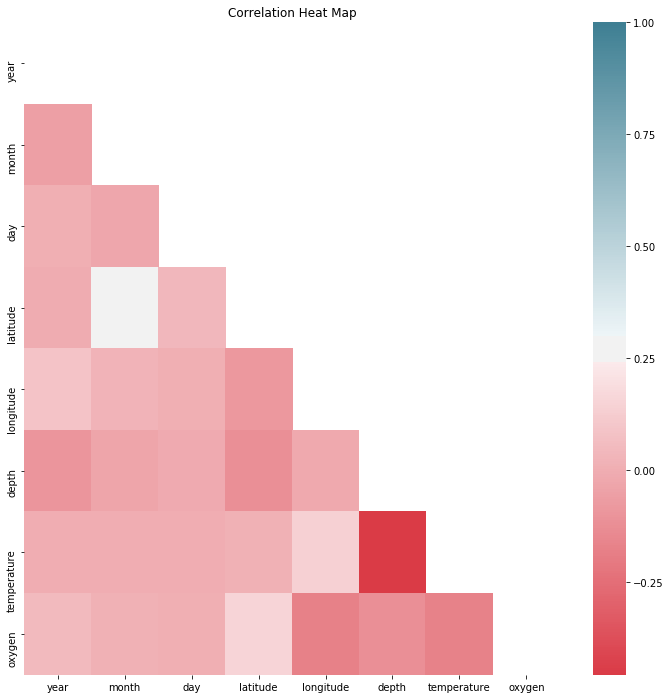

In [39]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap)
ax.set_title("Correlation Heat Map")

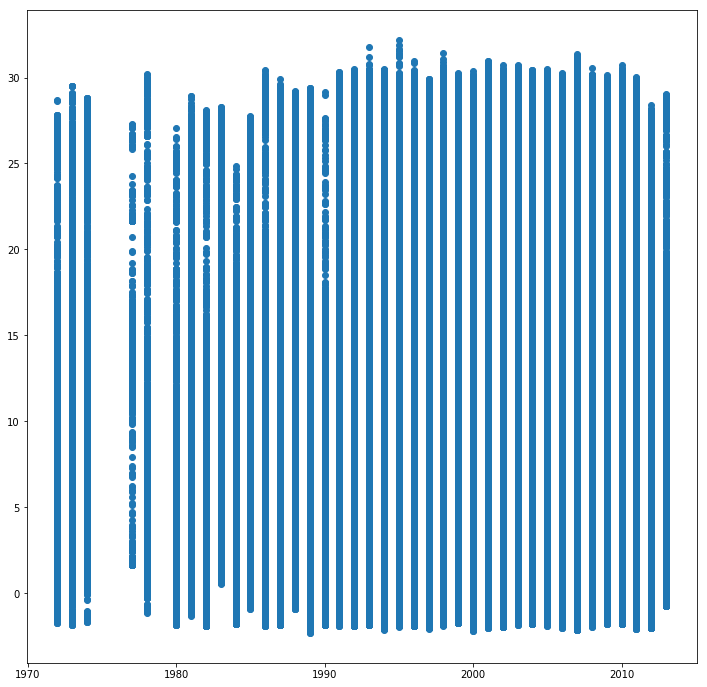

In [26]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(df['year'], df['temperature'])

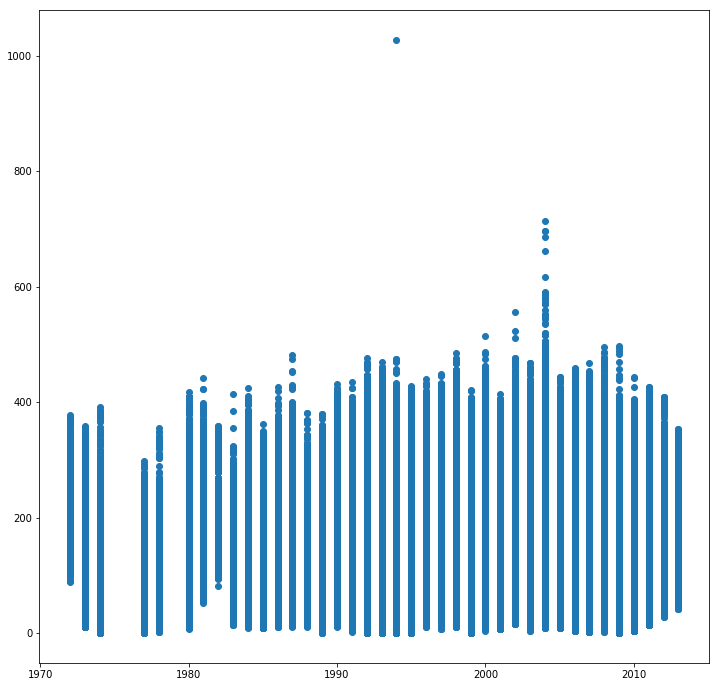

In [22]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(df['year'], df['oxygen'])

### What is that outlier?

In [23]:
df[df['oxygen']>800]

,year,month,day,latitude,longitude,depth,temperature,oxygen
164928,1994,9,11,50.0058,-144.971,3345.0,1.5171,1026.9


### Let's keep it!

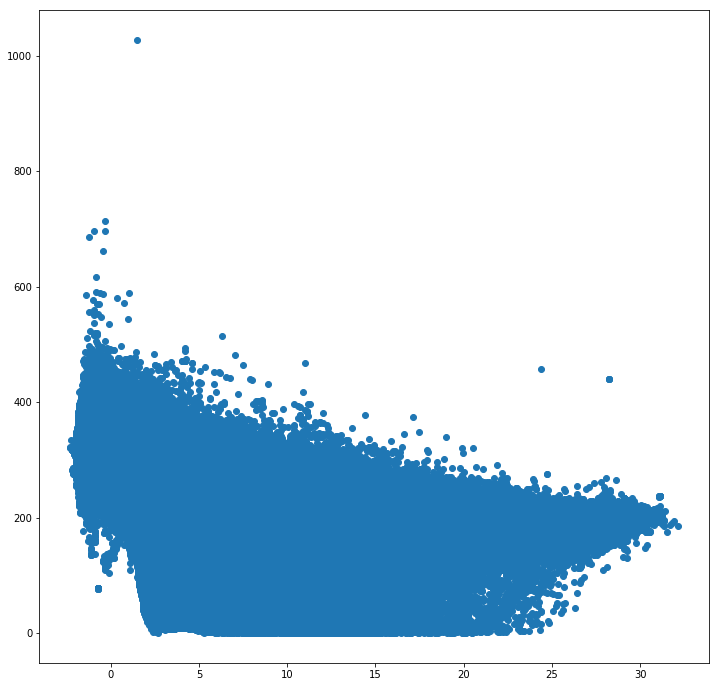

In [25]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(df['temperature'], df['oxygen'])

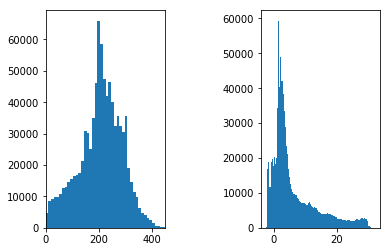

In [27]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_xlim(0, 450)
ax.hist(df['oxygen'], bins=100)

ax2 = fig.add_subplot(122)
ax2.hist(df['temperature'], bins=100)
fig.subplots_adjust(wspace=0.8)

# Question:
Are ocean temperature and dissolved oxygen correlated?

## Hypothesis testing framework:
- H0: There is no difference
- H1: There is a difference 
- Significance level: alpha=0.05
- Chosen test: t-test, because

### Scatter Matrix

In [ ]:
_ = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde')

### Univariate Plots

In [ ]:
fig = plt.figure()

for name, ax in zip(numeric_predictors, axs.flatten()):
    plot_univariate_smooth(ax, 
                           balance[name].values.reshape(-1, 1),
                           balance['Balance'],
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()